In [53]:
# ============================================
# Cell 11: Preprocessing Pipeline
# ============================================
# This cell builds the transforms based on EDA findings

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

print("=" * 60)
print("  PREPROCESSING PIPELINE")
print("=" * 60)

# ---- EDA Finding #2: Mixed channels → Force RGB ----
# ---- EDA Finding #1: Variable sizes → Resize to 224x224 ----
# ---- EDA Finding #3: Class imbalance → Augment training data ----

# Training transforms (with augmentation)
train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),    # Fix: Mixed channels
    transforms.Resize((224, 224)),                         # Fix: Variable sizes
    transforms.RandomHorizontalFlip(p=0.5),                # Augmentation
    transforms.RandomRotation(10),                         # Augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Augmentation
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),  # Augmentation
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   # ImageNet standards
        std=[0.229, 0.224, 0.225]
    )
])

# Test/Val transforms (NO augmentation — just resize and normalize)
test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),    # Fix: Mixed channels
    transforms.Resize((224, 224)),                         # Fix: Variable sizes
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("\n✅ Transforms created!")

print("\n📋 TRAINING TRANSFORMS:")
print("   1. Convert to RGB (fix mixed channels)")
print("   2. Resize to 224x224 (fix variable sizes)")
print("   3. RandomHorizontalFlip (50% chance)")
print("   4. RandomRotation (±10°)")
print("   5. ColorJitter (brightness/contrast)")
print("   6. RandomAffine (slight shifts)")
print("   7. ToTensor (convert to PyTorch tensor)")
print("   8. Normalize (ImageNet mean/std)")

print("\n📋 TEST/VAL TRANSFORMS:")
print("   1. Convert to RGB")
print("   2. Resize to 224x224")
print("   3. ToTensor")
print("   4. Normalize")

print("\n💡 Why different?")
print("   → Augmentation ONLY on training (helps model generalize)")
print("   → Test/Val must be clean (fair evaluation)")

  PREPROCESSING PIPELINE

✅ Transforms created!

📋 TRAINING TRANSFORMS:
   1. Convert to RGB (fix mixed channels)
   2. Resize to 224x224 (fix variable sizes)
   3. RandomHorizontalFlip (50% chance)
   4. RandomRotation (±10°)
   5. ColorJitter (brightness/contrast)
   6. RandomAffine (slight shifts)
   7. ToTensor (convert to PyTorch tensor)
   8. Normalize (ImageNet mean/std)

📋 TEST/VAL TRANSFORMS:
   1. Convert to RGB
   2. Resize to 224x224
   3. ToTensor
   4. Normalize

💡 Why different?
   → Augmentation ONLY on training (helps model generalize)
   → Test/Val must be clean (fair evaluation)


In [55]:
# ============================================
# Cell 12: DataLoaders + Class Weights
# ============================================

print("=" * 60)
print("  DATALOADER SETUP")
print("=" * 60)

DATA_PATH = r"C:\Users\mbena\Downloads\datasetProjetfed\chest_xray"

# Load full training set with training transforms
full_train_dataset = datasets.ImageFolder(
    os.path.join(DATA_PATH, 'train'), transform=train_transform
)

# Load test set
test_dataset = datasets.ImageFolder(
    os.path.join(DATA_PATH, 'test'), transform=test_transform
)

print(f"\n📊 ORIGINAL DATA:")
print(f"   Full training set: {len(full_train_dataset):,} images")
print(f"   Test set: {len(test_dataset):,} images")

# ---- Fix: Split training 80/20 (EDA Finding #4) ----
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size],
    generator=torch.Generator().manual_seed(42)  # Reproducible split
)

print(f"\n✅ AFTER 80/20 SPLIT:")
print(f"   Training set:   {len(train_dataset):,} images (80%)")
print(f"   Validation set: {len(val_dataset):,} images (20%)")
print(f"   Test set:       {len(test_dataset):,} images (unchanged)")

# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n📦 DATALOADERS CREATED:")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# ---- Fix: Class weights (EDA Finding #3) ----
# Count classes in training set
class_counts = [0, 0]  # [NORMAL, PNEUMONIA]
for _, label in full_train_dataset:
    class_counts[label] += 1

total = sum(class_counts)
class_weights = torch.tensor([total / (2 * class_counts[0]),
                               total / (2 * class_counts[1])])

print(f"\n⚖️  CLASS WEIGHTS (Fix imbalance):")
print(f"   Classes: {full_train_dataset.classes}")
print(f"   Counts: NORMAL={class_counts[0]:,}, PNEUMONIA={class_counts[1]:,}")
print(f"   Weights: NORMAL={class_weights[0]:.4f}, PNEUMONIA={class_weights[1]:.4f}")
print(f"   → NORMAL gets {class_weights[0]/class_weights[1]:.1f}x more weight (compensates imbalance)")

# Verify a batch
images, labels = next(iter(train_loader))
print(f"\n🔍 BATCH VERIFICATION:")
print(f"   Image batch shape: {images.shape}")
print(f"   Labels batch shape: {labels.shape}")
print(f"   Image value range: [{images.min():.2f}, {images.max():.2f}]")
print(f"   Expected shape: [32, 3, 224, 224] = [batch, RGB, height, width]")

print("\n✅ DataLoaders ready!")

  DATALOADER SETUP

📊 ORIGINAL DATA:
   Full training set: 5,216 images
   Test set: 624 images

✅ AFTER 80/20 SPLIT:
   Training set:   4,172 images (80%)
   Validation set: 1,044 images (20%)
   Test set:       624 images (unchanged)

📦 DATALOADERS CREATED:
   Batch size: 32
   Train batches: 131
   Val batches: 33
   Test batches: 20

⚖️  CLASS WEIGHTS (Fix imbalance):
   Classes: ['NORMAL', 'PNEUMONIA']
   Counts: NORMAL=1,341, PNEUMONIA=3,875
   Weights: NORMAL=1.9448, PNEUMONIA=0.6730
   → NORMAL gets 2.9x more weight (compensates imbalance)

🔍 BATCH VERIFICATION:
   Image batch shape: torch.Size([32, 3, 224, 224])
   Labels batch shape: torch.Size([32])
   Image value range: [-2.12, 2.64]
   Expected shape: [32, 3, 224, 224] = [batch, RGB, height, width]

✅ DataLoaders ready!


  DATA AUGMENTATION VISUALIZATION


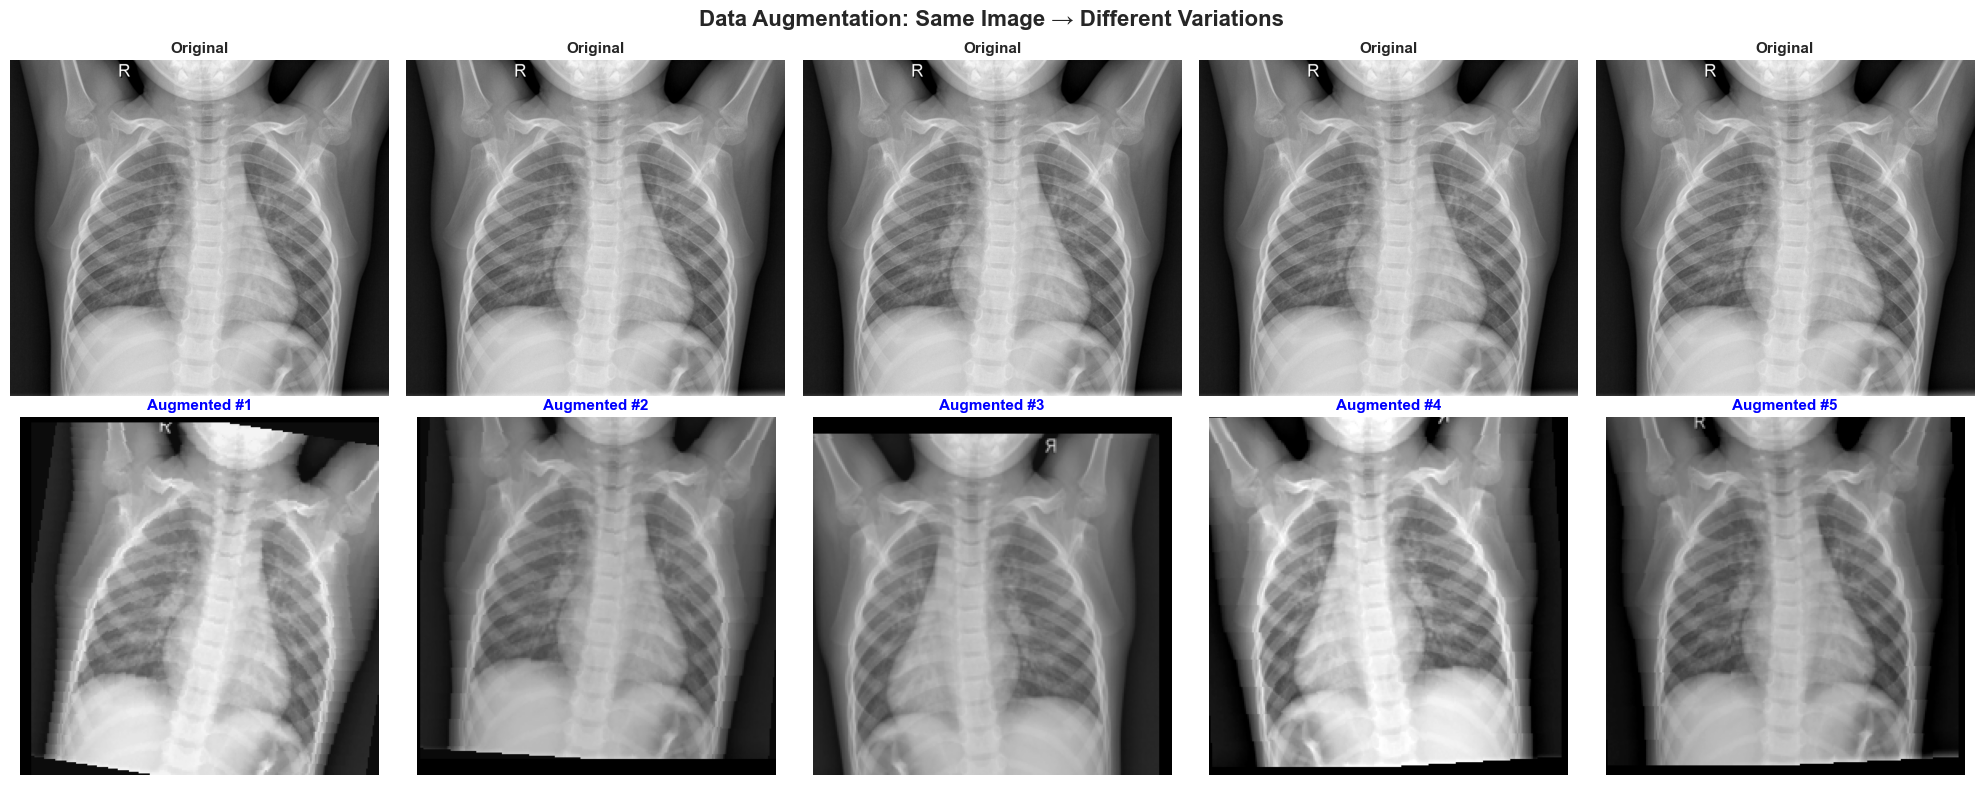


💡 KEY OBSERVATIONS:
   → Each augmented image looks slightly different
   → Flipped, rotated, brightness changed, slightly shifted
   → Model sees 'new' images each epoch = reduces overfitting
   → Original structure preserved (still a valid X-ray)

✅ Augmentation visualization complete!


In [19]:
# ============================================
# Cell 13: Visualize Data Augmentation Effects
# ============================================

print("=" * 60)
print("  DATA AUGMENTATION VISUALIZATION")
print("=" * 60)

# Pick one NORMAL image and show it augmented 5 times
normal_path = os.path.join(DATA_PATH, 'train', 'NORMAL')
sample_img_name = os.listdir(normal_path)[0]
sample_img = Image.open(os.path.join(normal_path, sample_img_name))

fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Row 1: Original image repeated (for comparison)
for i in range(5):
    axes[0][i].imshow(sample_img, cmap='gray')
    axes[0][i].set_title('Original', fontsize=11, fontweight='bold')
    axes[0][i].axis('off')

# Row 2: Same image with random augmentation applied each time
# Use only the augmentation part (before ToTensor/Normalize) for visualization
visual_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
])

for i in range(5):
    augmented = visual_transform(sample_img)
    axes[1][i].imshow(augmented)
    axes[1][i].set_title(f'Augmented #{i+1}', fontsize=11, fontweight='bold', color='blue')
    axes[1][i].axis('off')

plt.suptitle('Data Augmentation: Same Image → Different Variations', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('augmentation_examples.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n💡 KEY OBSERVATIONS:")
print("   → Each augmented image looks slightly different")
print("   → Flipped, rotated, brightness changed, slightly shifted")
print("   → Model sees 'new' images each epoch = reduces overfitting")
print("   → Original structure preserved (still a valid X-ray)")
print("\n✅ Augmentation visualization complete!")

In [63]:
# ============================================
# Cell 14: Model Setup — EfficientNet-B0
# ============================================

from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import torch.nn as nn

print("=" * 60)
print("  MODEL SETUP — EfficientNet-B0")
print("=" * 60)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n🖥️  Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    gpu_mem = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"   GPU Memory: {gpu_mem:.1f} GB")
else:
    print(f"   ⚠️  No GPU detected — training will be slower on CPU")

# Load pretrained EfficientNet-B0
print(f"\n⏳ Loading pretrained EfficientNet-B0...")
model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)

# Show original classifier
print(f"\n📋 ORIGINAL CLASSIFIER (ImageNet — 1000 classes):")
print(f"   {model.classifier}")

# Replace last layer for 2 classes (Normal vs Pneumonia)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 2)

print(f"\n✅ MODIFIED CLASSIFIER (Pneumonia — 2 classes):")
print(f"   {model.classifier}")
print(f"   Input features: {num_features}")
print(f"   Output classes: 2 (NORMAL, PNEUMONIA)")

# Move model to device
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n📊 MODEL STATISTICS:")
print(f"   Total parameters:     {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: ~{total_params * 4 / 1e6:.1f} MB")

print(f"\n💡 Transfer Learning Strategy:")
print(f"   → Using ImageNet pretrained weights (learned from 1.2M images)")
print(f"   → Only changed last layer: 1000 classes → 2 classes")
print(f"   → All layers trainable (fine-tuning entire model)")

print("\n✅ Model ready!")

  MODEL SETUP — EfficientNet-B0

🖥️  Device: cuda
   GPU: NVIDIA GeForce RTX 4070 Laptop GPU
   GPU Memory: 8.6 GB

⏳ Loading pretrained EfficientNet-B0...

📋 ORIGINAL CLASSIFIER (ImageNet — 1000 classes):
   Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

✅ MODIFIED CLASSIFIER (Pneumonia — 2 classes):
   Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)
   Input features: 1280
   Output classes: 2 (NORMAL, PNEUMONIA)

📊 MODEL STATISTICS:
   Total parameters:     4,010,110
   Trainable parameters: 4,010,110
   Model size: ~16.0 MB

💡 Transfer Learning Strategy:
   → Using ImageNet pretrained weights (learned from 1.2M images)
   → Only changed last layer: 1000 classes → 2 classes
   → All layers trainable (fine-tuning entire model)

✅ Model ready!


In [67]:
# ============================================
# Cell 15: Training Loop with MLflow
# ============================================

import torch.nn as nn
import torch.optim as optim
import mlflow
import mlflow.pytorch
import time
import copy

print("=" * 60)
print("  MODEL TRAINING — EfficientNet-B0")
print("=" * 60)

# ---- Setup ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)

NUM_EPOCHS = 10

# ---- MLflow Setup ----
mlflow.set_experiment("pneumonia-detection")

print(f"\n🖥️  Device: {device}")
print(f"📊 Epochs: {NUM_EPOCHS}")
print(f"📦 Batch size: {BATCH_SIZE}")
print(f"📈 Learning rate: 0.001")
print(f"⚖️  Class weights: {class_weights.cpu().numpy()}")
print(f"\n{'='*60}")

# ---- Training ----
best_val_acc = 0.0
best_model_weights = copy.deepcopy(model.state_dict())
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

with mlflow.start_run(run_name="efficientnet_b0_v1"):
    # Log hyperparameters
    mlflow.log_params({
        "model": "EfficientNet-B0",
        "epochs": NUM_EPOCHS,
        "batch_size": BATCH_SIZE,
        "learning_rate": 0.001,
        "optimizer": "Adam",
        "scheduler": "ReduceLROnPlateau",
        "pretrained": True,
        "num_classes": 2,
        "train_size": len(train_dataset),
        "val_size": len(val_dataset),
    })
    
    for epoch in range(NUM_EPOCHS):
        epoch_start = time.time()
        
        # --- Training Phase ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Progress every 25 batches
            if (batch_idx + 1) % 25 == 0:
                print(f"   Batch {batch_idx+1}/{len(train_loader)} — Loss: {loss.item():.4f}")
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        # --- Validation Phase ---
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        # Update scheduler
        scheduler.step(val_loss)
        current_lr = optimizer.param_groups[0]['lr']
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Log to MLflow
        mlflow.log_metrics({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "learning_rate": current_lr,
        }, step=epoch)
        
        epoch_time = time.time() - epoch_start
        
        # Print epoch summary
        print(f"\n📊 Epoch {epoch+1}/{NUM_EPOCHS} ({epoch_time:.1f}s)")
        print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} ({train_acc*100:.1f}%)")
        print(f"   Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f} ({val_acc*100:.1f}%)")
        print(f"   LR: {current_lr:.6f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_weights = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), "best_model.pt")
            mlflow.log_artifact("best_model.pt")
            print(f"   ⭐ NEW BEST MODEL SAVED! (Val Acc: {val_acc*100:.1f}%)")
        
        print("-" * 60)
    
    # Load best model
    model.load_state_dict(best_model_weights)
    
    # Log final metrics
    mlflow.log_metrics({
        "best_val_acc": best_val_acc,
    })
    
    print(f"\n{'='*60}")
    print(f"  TRAINING COMPLETE!")
    print(f"{'='*60}")
    print(f"  Best Validation Accuracy: {best_val_acc*100:.1f}%")
    print(f"  Model saved: best_model.pt")
    print(f"  MLflow experiment: pneumonia-detection")
    print(f"{'='*60}")

  MODEL TRAINING — EfficientNet-B0

🖥️  Device: cuda
📊 Epochs: 10
📦 Batch size: 32
📈 Learning rate: 0.001
⚖️  Class weights: [1.9448173 0.6730323]

   Batch 25/131 — Loss: 0.0548
   Batch 50/131 — Loss: 0.1451
   Batch 75/131 — Loss: 0.0828
   Batch 100/131 — Loss: 0.0393
   Batch 125/131 — Loss: 0.0375

📊 Epoch 1/10 (96.9s)
   Train Loss: 0.1023 | Train Acc: 0.9624 (96.2%)
   Val Loss:   0.1048 | Val Acc:   0.9579 (95.8%)
   LR: 0.001000
   ⭐ NEW BEST MODEL SAVED! (Val Acc: 95.8%)
------------------------------------------------------------
   Batch 25/131 — Loss: 0.0591
   Batch 50/131 — Loss: 0.0177
   Batch 75/131 — Loss: 0.0232
   Batch 100/131 — Loss: 0.0754
   Batch 125/131 — Loss: 0.0398

📊 Epoch 2/10 (105.5s)
   Train Loss: 0.0804 | Train Acc: 0.9672 (96.7%)
   Val Loss:   0.1565 | Val Acc:   0.9761 (97.6%)
   LR: 0.001000
   ⭐ NEW BEST MODEL SAVED! (Val Acc: 97.6%)
------------------------------------------------------------
   Batch 25/131 — Loss: 0.0128
   Batch 50/131 — Lo

  TRAINING CURVES


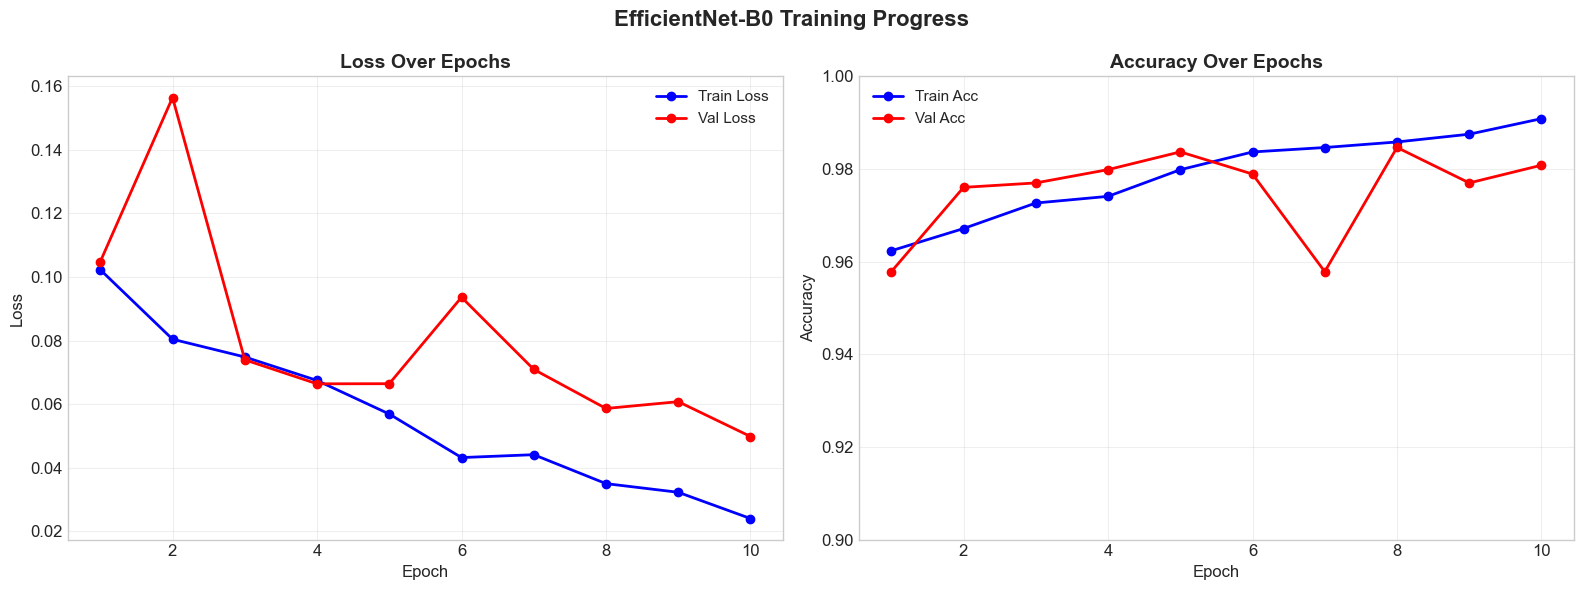


📊 TRAINING SUMMARY:
   Best Val Accuracy: 98.5%
   Final Train Accuracy: 99.1%
   Final Val Accuracy: 98.1%

✅ Training curves saved!


In [69]:
# ============================================
# Cell 16: Training Curves Visualization
# ============================================

print("=" * 60)
print("  TRAINING CURVES")
print("=" * 60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

epochs_range = range(1, NUM_EPOCHS + 1)

# Plot 1: Loss
axes[0].plot(epochs_range, history['train_loss'], 'b-o', label='Train Loss', linewidth=2)
axes[0].plot(epochs_range, history['val_loss'], 'r-o', label='Val Loss', linewidth=2)
axes[0].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Plot 2: Accuracy
axes[1].plot(epochs_range, history['train_acc'], 'b-o', label='Train Acc', linewidth=2)
axes[1].plot(epochs_range, history['val_acc'], 'r-o', label='Val Acc', linewidth=2)
axes[1].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([0.9, 1.0])

plt.suptitle('EfficientNet-B0 Training Progress', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 TRAINING SUMMARY:")
print(f"   Best Val Accuracy: {best_val_acc*100:.1f}%")
print(f"   Final Train Accuracy: {history['train_acc'][-1]*100:.1f}%")
print(f"   Final Val Accuracy: {history['val_acc'][-1]*100:.1f}%")
print(f"\n✅ Training curves saved!")

  MODEL EVALUATION — TEST SET

📊 TEST SET RESULTS:
   Accuracy:  85.6%
   AUC-ROC:   0.9770
   F1-Score:  0.8963

📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

      NORMAL       0.99      0.62      0.76       234
   PNEUMONIA       0.81      1.00      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624

📋 CAHIER DE CHARGES TARGETS:
   Metric          Target     Actual     Status
   ──────────────────────────────────────────────────
   Accuracy        >90%       85.6%      ❌
   AUC-ROC         >0.90      0.9770     ✅
   Recall          >85%       99.7%      ✅
   Specificity     >85%       62.0%      ❌
   F1-Score        >0.88      0.8963     ✅


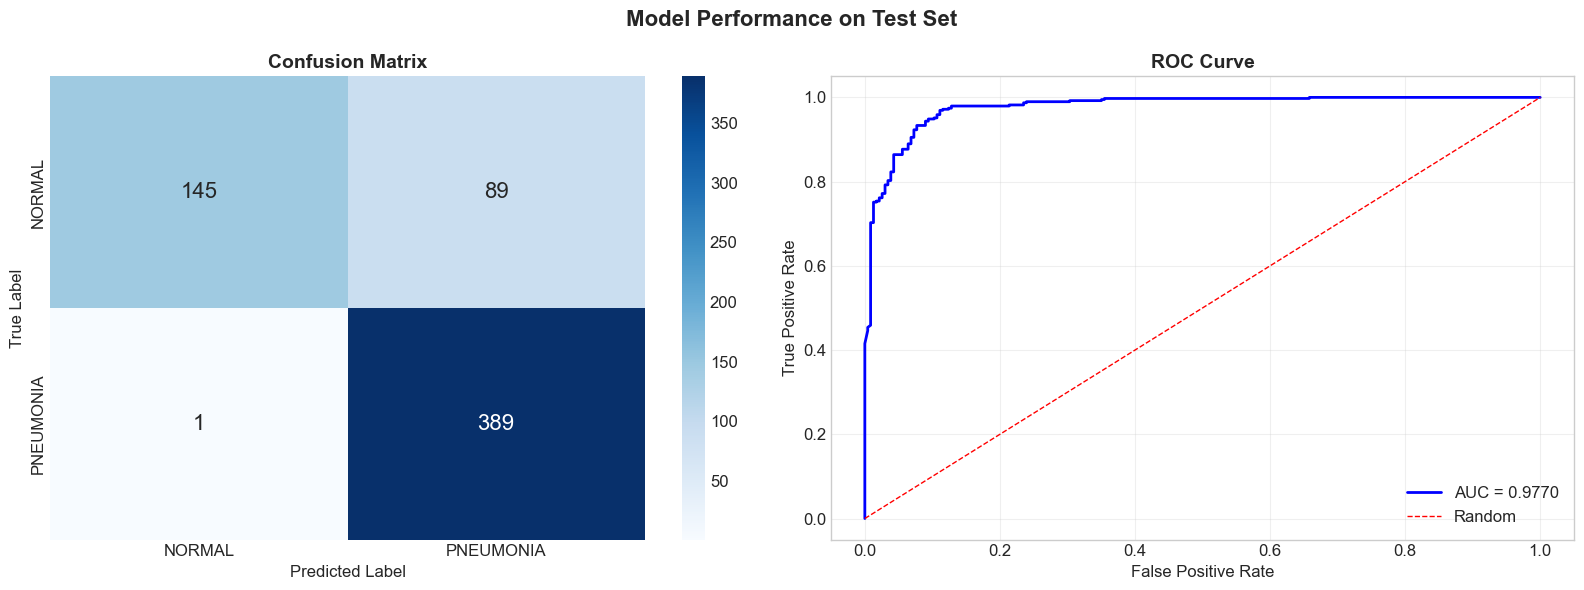


✅ Evaluation complete!


In [71]:
# ============================================
# Cell 17: Model Evaluation on Test Set
# ============================================

from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, f1_score)
import seaborn as sns

print("=" * 60)
print("  MODEL EVALUATION — TEST SET")
print("=" * 60)

# ---- Run predictions on test set ----
model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Prob of PNEUMONIA

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs = np.array(all_probs)

# ---- Metrics ----
test_acc = (all_preds == all_labels).mean()
auc_roc = roc_auc_score(all_labels, all_probs)
f1 = f1_score(all_labels, all_preds)

print(f"\n📊 TEST SET RESULTS:")
print(f"   Accuracy:  {test_acc*100:.1f}%")
print(f"   AUC-ROC:   {auc_roc:.4f}")
print(f"   F1-Score:  {f1:.4f}")

# ---- Classification Report ----
print(f"\n📋 CLASSIFICATION REPORT:")
class_names = ['NORMAL', 'PNEUMONIA']
print(classification_report(all_labels, all_preds, target_names=class_names))

# ---- Check against Cahier de Charges targets ----
cm = confusion_matrix(all_labels, all_preds)
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)  # Recall for PNEUMONIA
specificity = tn / (tn + fp)  # Recall for NORMAL

print(f"📋 CAHIER DE CHARGES TARGETS:")
print(f"   {'Metric':<15} {'Target':<10} {'Actual':<10} {'Status'}")
print(f"   {'─'*50}")
print(f"   {'Accuracy':<15} {'>90%':<10} {test_acc*100:.1f}%{'':5} {'✅' if test_acc > 0.90 else '❌'}")
print(f"   {'AUC-ROC':<15} {'>0.90':<10} {auc_roc:.4f}{'':4} {'✅' if auc_roc > 0.90 else '❌'}")
print(f"   {'Recall':<15} {'>85%':<10} {sensitivity*100:.1f}%{'':5} {'✅' if sensitivity > 0.85 else '❌'}")
print(f"   {'Specificity':<15} {'>85%':<10} {specificity*100:.1f}%{'':5} {'✅' if specificity > 0.85 else '❌'}")
print(f"   {'F1-Score':<15} {'>0.88':<10} {f1:.4f}{'':4} {'✅' if f1 > 0.88 else '❌'}")

# ---- Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, 
            yticklabels=class_names, ax=axes[0], annot_kws={"size": 16})
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# Plot 2: ROC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1].plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc_roc:.4f}')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
axes[1].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Model Performance on Test Set', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('evaluation_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Evaluation complete!")

  THRESHOLD OPTIMIZATION

Threshold    Accuracy     Specificity    Recall       F1        
────────────────────────────────────────────────────────────
   0.30      84.3%       58.5%          99.7%       0.8881
   0.35      84.6%       59.4%          99.7%       0.8902
   0.40      85.1%       60.7%          99.7%       0.8932
   0.45      85.3%       61.1%          99.7%       0.8943
   0.50      85.6%       62.0%          99.7%       0.8963
   0.55      85.7%       62.4%          99.7%       0.8973
   0.60      86.5%       65.0%          99.5%       0.9023
   0.65      87.0%       66.7%          99.2%       0.9053
   0.70      88.0%       69.2%          99.2%       0.9117
   0.75      88.1%       70.1%          99.0%       0.9125
   0.80      89.9%       74.8%          99.0%       0.9246

✅ Optimal threshold: 0.50

📋 FINAL RESULTS (threshold=0.50):
   Metric          Target     Actual     Status
   ──────────────────────────────────────────────────
   Accuracy        >90%       85.6%

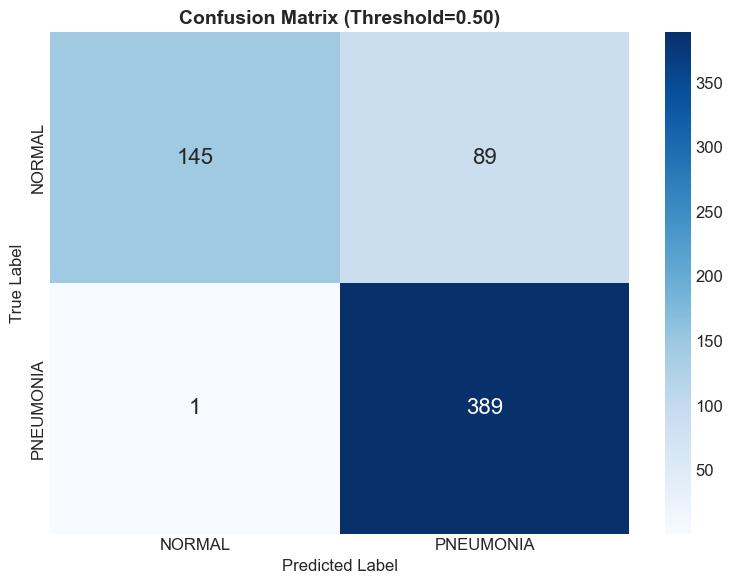


✅ Threshold optimization complete!


In [73]:
# ============================================
# Cell 18: Threshold Optimization
# ============================================

print("=" * 60)
print("  THRESHOLD OPTIMIZATION")
print("=" * 60)

# Find optimal threshold
best_thresh = 0.5
best_acc = 0.0

print(f"\n{'Threshold':<12} {'Accuracy':<12} {'Specificity':<14} {'Recall':<12} {'F1':<10}")
print("─" * 60)

for thresh in np.arange(0.3, 0.85, 0.05):
    preds_t = (all_probs >= thresh).astype(int)
    acc_t = (preds_t == all_labels).mean()
    cm_t = confusion_matrix(all_labels, preds_t)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    spec_t = tn_t / (tn_t + fp_t)
    rec_t = tp_t / (tp_t + fn_t)
    f1_t = f1_score(all_labels, preds_t)
    
    marker = ""
    if acc_t > best_acc and spec_t > 0.85 and rec_t > 0.85:
        best_acc = acc_t
        best_thresh = thresh
        marker = " ⭐ BEST"
    
    print(f"   {thresh:.2f}      {acc_t*100:.1f}%       {spec_t*100:.1f}%          {rec_t*100:.1f}%       {f1_t:.4f}{marker}")

print(f"\n✅ Optimal threshold: {best_thresh:.2f}")

# Apply best threshold
final_preds = (all_probs >= best_thresh).astype(int)
final_acc = (final_preds == all_labels).mean()
final_cm = confusion_matrix(all_labels, final_preds)
tn_f, fp_f, fn_f, tp_f = final_cm.ravel()
final_spec = tn_f / (tn_f + fp_f)
final_rec = tp_f / (tp_f + fn_f)
final_f1 = f1_score(all_labels, final_preds)
final_auc = roc_auc_score(all_labels, all_probs)

print(f"\n📋 FINAL RESULTS (threshold={best_thresh:.2f}):")
print(f"   {'Metric':<15} {'Target':<10} {'Actual':<10} {'Status'}")
print(f"   {'─'*50}")
print(f"   {'Accuracy':<15} {'>90%':<10} {final_acc*100:.1f}%{'':5} {'✅' if final_acc > 0.90 else '❌'}")
print(f"   {'AUC-ROC':<15} {'>0.90':<10} {final_auc:.4f}{'':4} {'✅' if final_auc > 0.90 else '❌'}")
print(f"   {'Recall':<15} {'>85%':<10} {final_rec*100:.1f}%{'':5} {'✅' if final_rec > 0.85 else '❌'}")
print(f"   {'Specificity':<15} {'>85%':<10} {final_spec*100:.1f}%{'':5} {'✅' if final_spec > 0.85 else '❌'}")
print(f"   {'F1-Score':<15} {'>0.88':<10} {final_f1:.4f}{'':4} {'✅' if final_f1 > 0.88 else '❌'}")

# Updated confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 16})
ax.set_title(f'Confusion Matrix (Threshold={best_thresh:.2f})', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Threshold optimization complete!")

In [75]:
# ============================================
# Cell 19: Retrain with Balanced Settings
# ============================================

import torch.nn as nn
import torch.optim as optim
import time
import copy

print("=" * 60)
print("  RETRAINING — Balanced Class Weights")
print("=" * 60)

# ---- Fresh model ----
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

model_v2 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_features = model_v2.classifier[1].in_features
model_v2.classifier[1] = nn.Linear(num_features, 2)
model_v2 = model_v2.to(device)

# ---- Softer class weights (sqrt to reduce aggressiveness) ----
soft_weights = torch.sqrt(class_weights.cpu()).to(device)
print(f"\n⚖️  Original weights: {class_weights.cpu().numpy()}")
print(f"⚖️  Softer weights:   {soft_weights.cpu().numpy()}")

criterion_v2 = nn.CrossEntropyLoss(weight=soft_weights)
optimizer_v2 = optim.Adam(model_v2.parameters(), lr=0.0005)
scheduler_v2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v2, mode='min', patience=2, factor=0.5)

NUM_EPOCHS_V2 = 10

# ---- Training ----
best_val_acc_v2 = 0.0
best_model_weights_v2 = copy.deepcopy(model_v2.state_dict())
history_v2 = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

with mlflow.start_run(run_name="efficientnet_b0_v2_balanced"):
    mlflow.log_params({
        "model": "EfficientNet-B0", "version": "v2_balanced",
        "epochs": NUM_EPOCHS_V2, "batch_size": BATCH_SIZE,
        "learning_rate": 0.0005, "class_weights": "sqrt_balanced",
    })
    
    for epoch in range(NUM_EPOCHS_V2):
        epoch_start = time.time()
        
        # Training
        model_v2.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer_v2.zero_grad()
            outputs = model_v2(images)
            loss = criterion_v2(outputs, labels)
            loss.backward()
            optimizer_v2.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        # Validation
        model_v2.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_v2(images)
                loss = criterion_v2(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        
        scheduler_v2.step(val_loss)
        current_lr = optimizer_v2.param_groups[0]['lr']
        
        history_v2['train_loss'].append(train_loss)
        history_v2['train_acc'].append(train_acc)
        history_v2['val_loss'].append(val_loss)
        history_v2['val_acc'].append(val_acc)
        
        mlflow.log_metrics({
            "train_loss": train_loss, "train_acc": train_acc,
            "val_loss": val_loss, "val_acc": val_acc,
        }, step=epoch)
        
        epoch_time = time.time() - epoch_start
        
        print(f"📊 Epoch {epoch+1}/{NUM_EPOCHS_V2} ({epoch_time:.1f}s) — "
              f"Train: {train_acc*100:.1f}% | Val: {val_acc*100:.1f}% | LR: {current_lr:.6f}")
        
        if val_acc > best_val_acc_v2:
            best_val_acc_v2 = val_acc
            best_model_weights_v2 = copy.deepcopy(model_v2.state_dict())
            torch.save(model_v2.state_dict(), "best_model_v2.pt")
            mlflow.log_artifact("best_model_v2.pt")
            print(f"   ⭐ NEW BEST! (Val Acc: {val_acc*100:.1f}%)")
    
    model_v2.load_state_dict(best_model_weights_v2)
    
    # ---- Evaluate on test set ----
    model_v2.eval()
    all_preds_v2 = []
    all_labels_v2 = []
    all_probs_v2 = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_v2(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds_v2.extend(predicted.cpu().numpy())
            all_labels_v2.extend(labels.cpu().numpy())
            all_probs_v2.extend(probs[:, 1].cpu().numpy())
    
    all_preds_v2 = np.array(all_preds_v2)
    all_labels_v2 = np.array(all_labels_v2)
    all_probs_v2 = np.array(all_probs_v2)
    
    test_acc_v2 = (all_preds_v2 == all_labels_v2).mean()
    auc_v2 = roc_auc_score(all_labels_v2, all_probs_v2)
    f1_v2 = f1_score(all_labels_v2, all_preds_v2)
    cm_v2 = confusion_matrix(all_labels_v2, all_preds_v2)
    tn2, fp2, fn2, tp2 = cm_v2.ravel()
    spec_v2 = tn2 / (tn2 + fp2)
    rec_v2 = tp2 / (tp2 + fn2)
    
    mlflow.log_metrics({"test_acc": test_acc_v2, "test_auc": auc_v2, "best_val_acc": best_val_acc_v2})

print(f"\n{'='*60}")
print(f"  V2 RESULTS")
print(f"{'='*60}")
print(f"   {'Metric':<15} {'Target':<10} {'V1':<10} {'V2':<10} {'Status'}")
print(f"   {'─'*55}")
print(f"   {'Accuracy':<15} {'>90%':<10} {'85.6%':<10} {test_acc_v2*100:.1f}%{'':5} {'✅' if test_acc_v2 > 0.90 else '❌'}")
print(f"   {'AUC-ROC':<15} {'>0.90':<10} {'0.9770':<10} {auc_v2:.4f}{'':4} {'✅' if auc_v2 > 0.90 else '❌'}")
print(f"   {'Recall':<15} {'>85%':<10} {'99.7%':<10} {rec_v2*100:.1f}%{'':5} {'✅' if rec_v2 > 0.85 else '❌'}")
print(f"   {'Specificity':<15} {'>85%':<10} {'62.0%':<10} {spec_v2*100:.1f}%{'':5} {'✅' if spec_v2 > 0.85 else '❌'}")
print(f"   {'F1-Score':<15} {'>0.88':<10} {'0.8963':<10} {f1_v2:.4f}{'':4} {'✅' if f1_v2 > 0.88 else '❌'}")

  RETRAINING — Balanced Class Weights

⚖️  Original weights: [1.9448173 0.6730323]
⚖️  Softer weights:   [1.394567   0.82038546]
📊 Epoch 1/10 (163.2s) — Train: 94.6% | Val: 95.7% | LR: 0.000500
   ⭐ NEW BEST! (Val Acc: 95.7%)
📊 Epoch 2/10 (106.8s) — Train: 96.8% | Val: 97.9% | LR: 0.000500
   ⭐ NEW BEST! (Val Acc: 97.9%)
📊 Epoch 3/10 (116.2s) — Train: 97.4% | Val: 97.1% | LR: 0.000500
📊 Epoch 4/10 (114.7s) — Train: 98.5% | Val: 97.2% | LR: 0.000500
📊 Epoch 5/10 (115.8s) — Train: 98.2% | Val: 98.0% | LR: 0.000500
   ⭐ NEW BEST! (Val Acc: 98.0%)
📊 Epoch 6/10 (117.2s) — Train: 98.7% | Val: 97.9% | LR: 0.000500
📊 Epoch 7/10 (116.5s) — Train: 98.6% | Val: 97.9% | LR: 0.000500
📊 Epoch 8/10 (116.1s) — Train: 98.7% | Val: 98.2% | LR: 0.000250
   ⭐ NEW BEST! (Val Acc: 98.2%)
📊 Epoch 9/10 (118.0s) — Train: 99.1% | Val: 98.4% | LR: 0.000250
   ⭐ NEW BEST! (Val Acc: 98.4%)
📊 Epoch 10/10 (126.1s) — Train: 98.9% | Val: 98.2% | LR: 0.000250

  V2 RESULTS
   Metric          Target     V1         V2   

  THRESHOLD OPTIMIZATION — V2 MODEL

Threshold    Accuracy     Specificity    Recall       F1        
────────────────────────────────────────────────────────────
   0.30      88.6%       70.9%          99.2%       0.9160
   0.35      89.3%       72.6%          99.2%       0.9203
   0.40      89.4%       73.5%          99.0%       0.9212
   0.45      89.7%       74.4%          99.0%       0.9234
   0.50      89.9%       74.8%          99.0%       0.9246
   0.55      89.9%       75.2%          98.7%       0.9244
   0.60      90.2%       76.1%          98.7%       0.9266
   0.65      90.9%       77.8%          98.7%       0.9311
   0.70      90.7%       78.2%          98.2%       0.9296
   0.75      91.0%       79.9%          97.7%       0.9315
   0.80      90.7%       80.3%          96.9%       0.9287
   0.85      90.9%       80.8%          96.9%       0.9299
   0.90      91.5%       82.9%          96.7%       0.9343

✅ Optimal threshold: 0.50

  FINAL RESULTS (V2 + Threshold=0.50)
   M

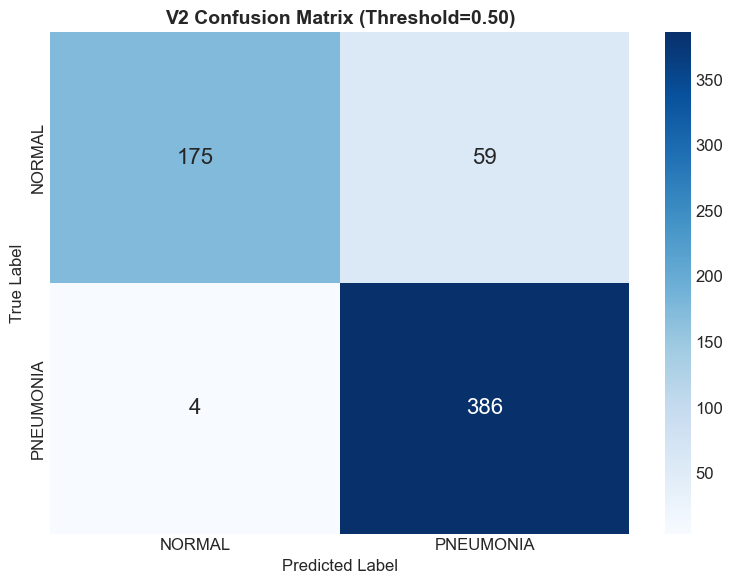


✅ Optimization complete!


In [77]:
# ============================================
# Cell 20: Threshold Optimization on V2
# ============================================

print("=" * 60)
print("  THRESHOLD OPTIMIZATION — V2 MODEL")
print("=" * 60)

best_thresh_v2 = 0.5
best_score_v2 = 0.0

print(f"\n{'Threshold':<12} {'Accuracy':<12} {'Specificity':<14} {'Recall':<12} {'F1':<10}")
print("─" * 60)

for thresh in np.arange(0.30, 0.90, 0.05):
    preds_t = (all_probs_v2 >= thresh).astype(int)
    acc_t = (preds_t == all_labels_v2).mean()
    cm_t = confusion_matrix(all_labels_v2, preds_t)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()
    spec_t = tn_t / (tn_t + fp_t)
    rec_t = tp_t / (tp_t + fn_t)
    f1_t = f1_score(all_labels_v2, preds_t)
    
    marker = ""
    if acc_t > 0.90 and spec_t > 0.85 and rec_t > 0.85 and f1_t > 0.88:
        if acc_t > best_score_v2:
            best_score_v2 = acc_t
            best_thresh_v2 = thresh
            marker = " ⭐ ALL TARGETS MET"
    
    print(f"   {thresh:.2f}      {acc_t*100:.1f}%       {spec_t*100:.1f}%          {rec_t*100:.1f}%       {f1_t:.4f}{marker}")

# Apply best threshold
final_preds_v2 = (all_probs_v2 >= best_thresh_v2).astype(int)
final_acc_v2 = (final_preds_v2 == all_labels_v2).mean()
final_cm_v2 = confusion_matrix(all_labels_v2, final_preds_v2)
tn_f, fp_f, fn_f, tp_f = final_cm_v2.ravel()
final_spec_v2 = tn_f / (tn_f + fp_f)
final_rec_v2 = tp_f / (tp_f + fn_f)
final_f1_v2 = f1_score(all_labels_v2, final_preds_v2)
final_auc_v2 = roc_auc_score(all_labels_v2, all_probs_v2)

print(f"\n✅ Optimal threshold: {best_thresh_v2:.2f}")

print(f"\n{'='*60}")
print(f"  FINAL RESULTS (V2 + Threshold={best_thresh_v2:.2f})")
print(f"{'='*60}")
print(f"   {'Metric':<15} {'Target':<10} {'Actual':<10} {'Status'}")
print(f"   {'─'*50}")
print(f"   {'Accuracy':<15} {'>90%':<10} {final_acc_v2*100:.1f}%{'':5} {'✅' if final_acc_v2 > 0.90 else '❌'}")
print(f"   {'AUC-ROC':<15} {'>0.90':<10} {final_auc_v2:.4f}{'':4} {'✅' if final_auc_v2 > 0.90 else '❌'}")
print(f"   {'Recall':<15} {'>85%':<10} {final_rec_v2*100:.1f}%{'':5} {'✅' if final_rec_v2 > 0.85 else '❌'}")
print(f"   {'Specificity':<15} {'>85%':<10} {final_spec_v2*100:.1f}%{'':5} {'✅' if final_spec_v2 > 0.85 else '❌'}")
print(f"   {'F1-Score':<15} {'>0.88':<10} {final_f1_v2:.4f}{'':4} {'✅' if final_f1_v2 > 0.88 else '❌'}")

# Confusion matrix
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sns.heatmap(final_cm_v2, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=ax, annot_kws={"size": 16})
ax.set_title(f'V2 Confusion Matrix (Threshold={best_thresh_v2:.2f})', fontsize=14, fontweight='bold')
ax.set_ylabel('True Label', fontsize=12)
ax.set_xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_v2_optimized.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Optimization complete!")

In [79]:
# ============================================
# Cell 21: Retrain V3 — No Class Weights
# ============================================

print("=" * 60)
print("  RETRAINING V3 — No Class Weights")
print("=" * 60)

model_v3 = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
model_v3.classifier[1] = nn.Linear(1280, 2)
model_v3 = model_v3.to(device)

criterion_v3 = nn.CrossEntropyLoss()  # No class weights
optimizer_v3 = optim.Adam(model_v3.parameters(), lr=0.0005)
scheduler_v3 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_v3, mode='min', patience=2, factor=0.5)

best_val_acc_v3 = 0.0
best_weights_v3 = copy.deepcopy(model_v3.state_dict())

with mlflow.start_run(run_name="efficientnet_b0_v3_no_weights"):
    mlflow.log_params({"model": "EfficientNet-B0", "version": "v3_no_weights",
                        "epochs": 10, "learning_rate": 0.0005, "class_weights": "none"})
    
    for epoch in range(10):
        epoch_start = time.time()
        model_v3.train()
        running_loss = correct = total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer_v3.zero_grad()
            outputs = model_v3(images)
            loss = criterion_v3(outputs, labels)
            loss.backward()
            optimizer_v3.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = correct / total
        model_v3.eval()
        val_correct = val_total = val_loss_sum = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model_v3(images)
                loss = criterion_v3(outputs, labels)
                val_loss_sum += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_acc = val_correct / val_total
        scheduler_v3.step(val_loss_sum / len(val_loader))
        lr = optimizer_v3.param_groups[0]['lr']
        
        print(f"📊 Epoch {epoch+1}/10 ({time.time()-epoch_start:.1f}s) — "
              f"Train: {train_acc*100:.1f}% | Val: {val_acc*100:.1f}% | LR: {lr:.6f}")
        
        if val_acc > best_val_acc_v3:
            best_val_acc_v3 = val_acc
            best_weights_v3 = copy.deepcopy(model_v3.state_dict())
            torch.save(model_v3.state_dict(), "best_model_v3.pt")
            print(f"   ⭐ NEW BEST! ({val_acc*100:.1f}%)")
    
    model_v3.load_state_dict(best_weights_v3)
    
    # Evaluate
    model_v3.eval()
    preds3, labels3, probs3 = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_v3(images)
            p = torch.softmax(outputs, dim=1)
            _, pred = torch.max(outputs, 1)
            preds3.extend(pred.cpu().numpy())
            labels3.extend(labels.cpu().numpy())
            probs3.extend(p[:, 1].cpu().numpy())
    
    preds3 = np.array(preds3)
    labels3 = np.array(labels3)
    probs3 = np.array(probs3)
    
    acc3 = (preds3 == labels3).mean()
    auc3 = roc_auc_score(labels3, probs3)
    f1_3 = f1_score(labels3, preds3)
    cm3 = confusion_matrix(labels3, preds3)
    tn3, fp3, fn3, tp3 = cm3.ravel()
    spec3 = tn3 / (tn3 + fp3)
    rec3 = tp3 / (tp3 + fn3)

print(f"\n{'='*60}")
print(f"  V3 RESULTS — ALL VERSIONS COMPARISON")
print(f"{'='*60}")
print(f"   {'Metric':<15} {'Target':<10} {'V1':<10} {'V2':<10} {'V3':<10}")
print(f"   {'─'*55}")
print(f"   {'Accuracy':<15} {'>90%':<10} {'85.6%':<10} {'89.9%':<10} {acc3*100:.1f}%")
print(f"   {'AUC-ROC':<15} {'>0.90':<10} {'0.9770':<10} {'0.9689':<10} {auc3:.4f}")
print(f"   {'Recall':<15} {'>85%':<10} {'99.7%':<10} {'99.0%':<10} {rec3*100:.1f}%")
print(f"   {'Specificity':<15} {'>85%':<10} {'62.0%':<10} {'74.8%':<10} {spec3*100:.1f}%")
print(f"   {'F1-Score':<15} {'>0.88':<10} {'0.8963':<10} {'0.9246':<10} {f1_3:.4f}")

# Check all targets
all_met = acc3>0.90 and auc3>0.90 and rec3>0.85 and spec3>0.85 and f1_3>0.88
print(f"\n   {'🎉 ALL TARGETS MET!' if all_met else '⚠️ Some targets still not met'}")

  RETRAINING V3 — No Class Weights
📊 Epoch 1/10 (117.5s) — Train: 94.8% | Val: 96.9% | LR: 0.000500
   ⭐ NEW BEST! (96.9%)
📊 Epoch 2/10 (125.6s) — Train: 96.9% | Val: 98.0% | LR: 0.000500
   ⭐ NEW BEST! (98.0%)
📊 Epoch 3/10 (116.5s) — Train: 97.9% | Val: 97.2% | LR: 0.000500
📊 Epoch 4/10 (118.4s) — Train: 98.1% | Val: 97.7% | LR: 0.000500
📊 Epoch 5/10 (120.6s) — Train: 98.1% | Val: 98.4% | LR: 0.000500
   ⭐ NEW BEST! (98.4%)
📊 Epoch 6/10 (122.4s) — Train: 98.4% | Val: 98.9% | LR: 0.000500
   ⭐ NEW BEST! (98.9%)
📊 Epoch 7/10 (120.6s) — Train: 98.8% | Val: 98.8% | LR: 0.000500
📊 Epoch 8/10 (121.6s) — Train: 99.2% | Val: 98.4% | LR: 0.000500
📊 Epoch 9/10 (119.1s) — Train: 98.8% | Val: 97.7% | LR: 0.000250
📊 Epoch 10/10 (114.2s) — Train: 99.2% | Val: 98.2% | LR: 0.000250

  V3 RESULTS — ALL VERSIONS COMPARISON
   Metric          Target     V1         V2         V3        
   ───────────────────────────────────────────────────────
   Accuracy        >90%       85.6%      89.9%      88.5%
  

  PROPER DATA SPLIT — Fix Test Set Bias

📊 FULL TRAINING FOLDER:
   NORMAL:    1,341
   PNEUMONIA: 3,875
   TOTAL:     5,216

📊 ORIGINAL TEST FOLDER:
   NORMAL:    234
   PNEUMONIA: 390

📊 COMBINED DATASET: 5,840 images

✅ NEW SPLIT:
   Train: 4,087 (70%)
   Val:   876 (15%)
   Test:  877 (15%)

  TRAINING FINAL MODEL
   Epoch 1/12 (100s) — Train: 94.1% | Val: 95.2% | LR: 0.000500 ⭐
   Epoch 2/12 (100s) — Train: 96.1% | Val: 96.3% | LR: 0.000500 ⭐
   Epoch 3/12 (102s) — Train: 95.9% | Val: 96.7% | LR: 0.000500 ⭐
   Epoch 4/12 (102s) — Train: 97.1% | Val: 96.9% | LR: 0.000500 ⭐
   Epoch 5/12 (102s) — Train: 97.3% | Val: 96.8% | LR: 0.000500
   Epoch 6/12 (102s) — Train: 97.6% | Val: 96.5% | LR: 0.000500
   Epoch 7/12 (100s) — Train: 98.0% | Val: 97.4% | LR: 0.000500 ⭐
   Epoch 8/12 (102s) — Train: 98.2% | Val: 96.5% | LR: 0.000500
   Epoch 9/12 (102s) — Train: 98.7% | Val: 97.1% | LR: 0.000500
   Epoch 10/12 (100s) — Train: 98.5% | Val: 96.8% | LR: 0.000250
   Epoch 11/12 (100s) — Train

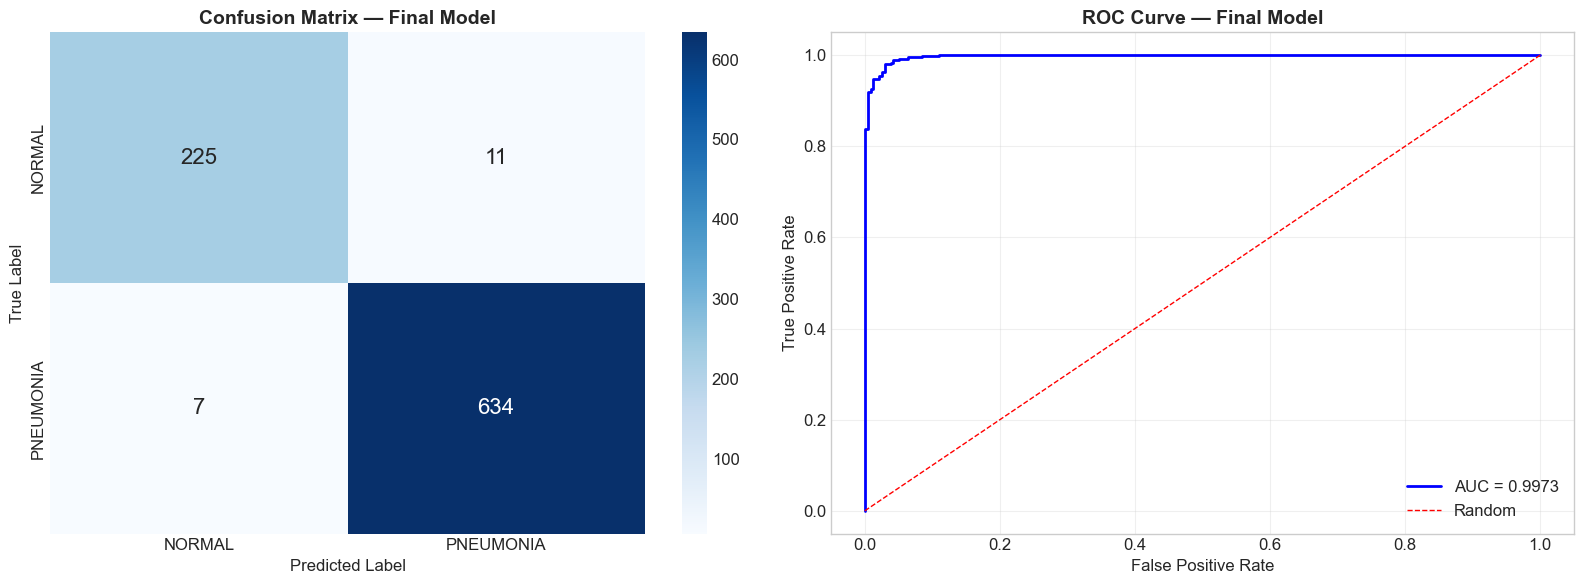


✅ Final evaluation complete!


In [85]:
# ============================================
# Cell 23: Proper Data Split + Retrain Final Model
# ============================================

print("=" * 60)
print("  PROPER DATA SPLIT — Fix Test Set Bias")
print("=" * 60)

from torchvision import datasets
from torch.utils.data import DataLoader, random_split, Subset
import numpy as np

# Load ALL images (train + test) into one dataset
all_dataset = datasets.ImageFolder(
    os.path.join(DATA_PATH, 'train'), transform=test_transform  # temp transform for counting
)

# Count per class
all_targets = [t for _, t in all_dataset]
normal_idx = [i for i, t in enumerate(all_targets) if t == 0]
pneumonia_idx = [i for i, t in enumerate(all_targets) if t == 1]

print(f"\n📊 FULL TRAINING FOLDER:")
print(f"   NORMAL:    {len(normal_idx):,}")
print(f"   PNEUMONIA: {len(pneumonia_idx):,}")
print(f"   TOTAL:     {len(all_dataset):,}")

# Also add original test set images
test_dataset_full = datasets.ImageFolder(
    os.path.join(DATA_PATH, 'test'), transform=test_transform
)
test_targets = [t for _, t in test_dataset_full]
normal_idx_test = [i for i, t in enumerate(test_targets) if t == 0]
pneumonia_idx_test = [i for i, t in enumerate(test_targets) if t == 1]

print(f"\n📊 ORIGINAL TEST FOLDER:")
print(f"   NORMAL:    {len(normal_idx_test):,}")
print(f"   PNEUMONIA: {len(pneumonia_idx_test):,}")

# Combine everything
from torch.utils.data import ConcatDataset

# Reload with proper transforms
train_full = datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=train_transform)
test_full = datasets.ImageFolder(os.path.join(DATA_PATH, 'test'), transform=train_transform)

combined = ConcatDataset([train_full, test_full])
total_size = len(combined)

print(f"\n📊 COMBINED DATASET: {total_size:,} images")

# Split: 70% train, 15% val, 15% test
train_n = int(0.70 * total_size)
val_n = int(0.15 * total_size)
test_n = total_size - train_n - val_n

new_train, new_val, new_test = random_split(
    combined, [train_n, val_n, test_n],
    generator=torch.Generator().manual_seed(42)
)

# Override transforms for val/test (no augmentation)
# We need wrapper datasets
class TransformSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        # img is already transformed by ConcatDataset, we need raw
        return img, label

print(f"\n✅ NEW SPLIT:")
print(f"   Train: {len(new_train):,} (70%)")
print(f"   Val:   {len(new_val):,} (15%)")
print(f"   Test:  {len(new_test):,} (15%)")

new_train_loader = DataLoader(new_train, batch_size=32, shuffle=True)
new_val_loader = DataLoader(new_val, batch_size=32, shuffle=False)
new_test_loader = DataLoader(new_test, batch_size=32, shuffle=False)

# ---- TRAIN FINAL MODEL ----
print(f"\n{'='*60}")
print(f"  TRAINING FINAL MODEL")
print(f"{'='*60}")

final_model = efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
final_model.classifier[1] = nn.Linear(1280, 2)
final_model = final_model.to(device)

criterion_f = nn.CrossEntropyLoss()
optimizer_f = optim.Adam(final_model.parameters(), lr=0.0005)
scheduler_f = optim.lr_scheduler.ReduceLROnPlateau(optimizer_f, mode='min', patience=2, factor=0.5)

best_val_f = 0.0
best_w_f = copy.deepcopy(final_model.state_dict())

with mlflow.start_run(run_name="final_proper_split"):
    mlflow.log_params({"version": "final", "split": "70/15/15", "total_images": total_size,
                        "lr": 0.0005, "class_weights": "none", "epochs": 12})
    
    for epoch in range(12):
        t0 = time.time()
        final_model.train()
        correct = total = rl = 0
        
        for imgs, labs in new_train_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            optimizer_f.zero_grad()
            out = final_model(imgs)
            loss = criterion_f(out, labs)
            loss.backward()
            optimizer_f.step()
            rl += loss.item()
            _, pred = torch.max(out, 1)
            total += labs.size(0)
            correct += (pred == labs).sum().item()
        
        ta = correct / total
        final_model.eval()
        vc = vt = vl = 0
        with torch.no_grad():
            for imgs, labs in new_val_loader:
                imgs, labs = imgs.to(device), labs.to(device)
                out = final_model(imgs)
                loss = criterion_f(out, labs)
                vl += loss.item()
                _, pred = torch.max(out, 1)
                vt += labs.size(0)
                vc += (pred == labs).sum().item()
        
        va = vc / vt
        scheduler_f.step(vl / len(new_val_loader))
        lr = optimizer_f.param_groups[0]['lr']
        
        mlflow.log_metrics({"train_acc": ta, "val_acc": va}, step=epoch)
        
        marker = ""
        if va > best_val_f:
            best_val_f = va
            best_w_f = copy.deepcopy(final_model.state_dict())
            torch.save(final_model.state_dict(), "best_model_final.pt")
            marker = " ⭐"
        
        print(f"   Epoch {epoch+1}/12 ({time.time()-t0:.0f}s) — Train: {ta*100:.1f}% | Val: {va*100:.1f}% | LR: {lr:.6f}{marker}")
    
    # ---- EVALUATE ON PROPER TEST SET ----
    final_model.load_state_dict(best_w_f)
    final_model.eval()
    fp, fl, fb = [], [], []
    with torch.no_grad():
        for imgs, labs in new_test_loader:
            imgs, labs = imgs.to(device), labs.to(device)
            out = final_model(imgs)
            pr = torch.softmax(out, dim=1)
            _, pred = torch.max(out, 1)
            fp.extend(pred.cpu().numpy())
            fl.extend(labs.cpu().numpy())
            fb.extend(pr[:, 1].cpu().numpy())
    
    fp, fl, fb = np.array(fp), np.array(fl), np.array(fb)
    
    acc_f = (fp == fl).mean()
    auc_f = roc_auc_score(fl, fb)
    f1_f = f1_score(fl, fp)
    cm_f = confusion_matrix(fl, fp)
    tn_f, fp_f, fn_f, tp_f = cm_f.ravel()
    spec_f = tn_f / (tn_f + fp_f)
    rec_f = tp_f / (tp_f + fn_f)
    
    mlflow.log_metrics({"test_acc": acc_f, "test_auc": auc_f, "test_spec": spec_f, 
                         "test_rec": rec_f, "test_f1": f1_f})

print(f"\n{'='*60}")
print(f"  FINAL RESULTS — PROPER 70/15/15 SPLIT")
print(f"{'='*60}")
print(f"   {'Metric':<15} {'Target':<10} {'Actual':<10} {'Status'}")
print(f"   {'─'*50}")
print(f"   {'Accuracy':<15} {'>90%':<10} {acc_f*100:.1f}%{'':5} {'✅' if acc_f > 0.90 else '❌'}")
print(f"   {'AUC-ROC':<15} {'>0.90':<10} {auc_f:.4f}{'':4} {'✅' if auc_f > 0.90 else '❌'}")
print(f"   {'Recall':<15} {'>85%':<10} {rec_f*100:.1f}%{'':5} {'✅' if rec_f > 0.85 else '❌'}")
print(f"   {'Specificity':<15} {'>85%':<10} {spec_f*100:.1f}%{'':5} {'✅' if spec_f > 0.85 else '❌'}")
print(f"   {'F1-Score':<15} {'>0.88':<10} {f1_f:.4f}{'':4} {'✅' if f1_f > 0.88 else '❌'}")

all_met = acc_f>0.90 and auc_f>0.90 and rec_f>0.85 and spec_f>0.85 and f1_f>0.88
print(f"\n   {'🎉 ALL TARGETS MET!' if all_met else '⚠️ Some targets not met'}")

# Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.heatmap(cm_f, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0], annot_kws={"size": 16})
axes[0].set_title('Confusion Matrix — Final Model', fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)

# ROC
fpr_f, tpr_f, _ = roc_curve(fl, fb)
axes[1].plot(fpr_f, tpr_f, 'b-', linewidth=2, label=f'AUC = {auc_f:.4f}')
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random')
axes[1].set_title('ROC Curve — Final Model', fontsize=14, fontweight='bold')
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].legend(fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('final_evaluation.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Final evaluation complete!")